# Imports

In [1]:
import sys
sys.path.append("../common/")

import pandas as pd
import numpy as np
import statsmodels as sm
from datetime import datetime

from statsmodels.regression.linear_model import OLS
from scipy.stats import pearsonr, Normal, lognorm

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

import psycopg
from utility import describe_table, SECRETS, CONNECTION_STRING

# Plot data

## Preprocessing

In [ ]:
assets = dict.fromkeys(["nasdaq_ohlc","bitcoin_ohlc","snp_ohlc","dow_jones_ohlc","gold_ohlc","oil_price"])
assets

In [ ]:
# can't handle oil
for asset in assets.keys():
    match asset:
        case "gold_ohlc":
            dt_selector = "dt"
        case "oil_price":
            continue
        case _:
            dt_selector = "ts"
    
    with psycopg.connect(CONNECTION_STRING) as conn:
        res = conn.execute(f"""
            SELECT
                bucket::date,
                avg(close) AS avg_close
            FROM (
                SELECT
                    {dt_selector},
                    time_bucket('1 month'::INTERVAL, {dt_selector}) AS bucket,
                    close
                FROM "{asset}"
            )
            GROUP BY bucket
            ORDER BY bucket;
        """)
    
    data = pd.DataFrame(res.fetchall(),columns=["date","avg_close"])
    data["date"] = data["date"].astype(str).map(datetime.fromisoformat)
    data = data.set_index("date").squeeze()
    data.name = asset
    assets[asset] = data.sort_index()

In [ ]:
with psycopg.connect(CONNECTION_STRING) as conn:
    res = conn.execute(f"""
        SELECT
            bucket::date,
            avg(price) AS avg_price
        FROM (
            SELECT
                time_bucket('1 month'::INTERVAL, dt) AS bucket,
                price
            FROM oil_price
        )
        GROUP BY bucket
        ORDER BY bucket;
    """)
data = pd.DataFrame(res.fetchall(),columns=["date","avg_close"])
data["date"] = data["date"].astype(str).map(datetime.fromisoformat)
data = data.set_index("date").squeeze()
data.name = "oil_price"
assets["oil_price"] = data.sort_index()

In [ ]:
price_data = pd.concat(
    assets.values(),
    axis="columns"
)[:"2025-07-01"]
price_data

In [ ]:
first_values = price_data.dropna(axis="rows").iloc[0]
first_values

In [ ]:
norm_data = price_data / first_values

## Plotting

In [ ]:
style_frame = pd.DataFrame(
    {
        "alias": ["bitcoin_ohlc", "nasdaq_ohlc", "snp_ohlc", "dow_jones_ohlc", "gold_ohlc", "oil_price"],
        "asset_name": ["Bitcoin", "NASDAQ", "S&P 500", "Dow Jones", "Gold", "Oil"],
        "color": ["#ff0000", "#0092BC", "#2F4F4F", "#62250B", "#E88F09", "#000000"],
        "style": ["solid"] * 6,
        "alpha": [1] * 6,
        "size": [2] * 6,
        "text_offset": [0, 0.15, 0.1, -0.05, -0.05, 0]
    }
)
style_frame = style_frame.set_index("alias")
style_frame

In [ ]:
from math import log

# Global >>>
bg_color = "#FFFFFF"

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(
    "Bitcoin's Average Monthly Price Compared To Chosen Assets",
    weight="bold"
)
fig.set_facecolor(bg_color)
ax.set_facecolor(bg_color)
# <<<

# Plotting >>>
new_index_order = ["nasdaq_ohlc", "snp_ohlc", "dow_jones_ohlc", "gold_ohlc", "oil_price", "bitcoin_ohlc"]
iter_data = norm_data.map(log).reindex(columns=new_index_order).items()
for name, asset in iter_data:
    style = style_frame.loc[name]
    ax.plot(
        asset,
        label=style["asset_name"],
        color=style["color"],
        alpha=style["alpha"],
        linewidth=style["size"],
        linestyle=style["style"]
    )

    ax.text(
        x=asset.index[-1] + pd.offsets.Day(70),
        y=asset.iloc[-1] - 0.15 + style["text_offset"],
        s=style["asset_name"],
        color=style["color"],
        alpha=style["alpha"]
    )
# <<<

# X-axis >>>
ax.spines['top'].set_visible(False)
ax.tick_params(axis='x', labelrotation=45)

ax.set_xticks(
    pd.date_range(start="2010-01-01", end="2025-08-01", freq="YE-JAN") - pd.offsets.Day(30)
)
ax.set_xticklabels(np.arange(2010,2026))

arr = norm_data.index.to_numpy()
quarters = pd.date_range(start=arr[0],end=arr[-1], freq="QE-DEC").to_numpy()
ax.set_xticks(quarters, minor=True)

ax.set_xlabel(
    "Year",
    weight="bold",
)

ax.text(
    x=(ax.get_xlim()[1] + ax.get_xlim()[0]) / 2,
    y=-5.5,
    s="Figure 1",
    ha="center",
    style="italic"
)
# <<<

# Y-axis >>>
ax.spines['right'].set_visible(False)
ax.set_ylabel(
    "Log ( Price Index )",
    weight="bold"
)
# <<<
pass

## Summary

* The data presented on the chart is normalized w.r.t. to (average) price of each asset in January 2012 and logarithimed. This was done for 2 reasons:
    * Differences in prices in 2012 and subsequent years and 
    * due to enourmous growth of Bitcoin in the last decade.
* Interpretation of the chart:
$$ROI_{k;t} := P_{k;t} - 1$$

$$d_{m;n} := ln(P_{m;n})$$

$$ROI_{k;t} = \frac{P_{0;t}}{P_{0;k}} - 1$$

$$ROI_{k;t} =  \frac{e^{d_{0;t}}}{e^{d_{0;k}}} - 1$$

$$ROI_{k;t} =  e^{d_{0;t}-d_{0;k}} - 1$$

Where each point on the chart is $(x; y) = (x; d_{2012;x})$\
* Thus, the interpretation is: $ ROI_{k;t} =  e^{y_t - y_k} - 1$
* This is however a relatively complex interpretation. The main goal of the chart is to compare price developments of Bitcoin and other chosen assets in appropriate manner 
* Coming at 1,702,630.84% (I) growth over the last ~13 years period Bitcoin's returns shadow any asset in a similar timeframe.
* Such comparisons are however very naive since Bitcoin was founded in 2009, which makes it, in the grand scheme of things, a brand new investment tool
* Remarkably, Bitcoin's growth has been very stable across the years resulting in ~5,38% a month. While other assets have experiences more stable growth rates (II) of about ~1% a month, they once again did not come close to Bitcoin's return
* It's needless to say, that past returns do not gurantee future growth especially amidst increased global uncertainty and regulation

* We will consider "real" returns (as in inflation-free) later in our analysis

### I

In [ ]:
((data.iloc[-1] / first_values - 1) * 100).round(2).astype(str) + "%"

### II

In [ ]:
subset = data.reset_index(drop=True).map(log)
subset["const"] = 1
subset["X"] = np.arange(1,len(subset)+1)
subset

In [ ]:
for asset in ["nasdaq_ohlc", "snp_ohlc", "dow_jones_ohlc", "gold_ohlc", "oil_price", "bitcoin_ohlc"]:
    frame = subset[["const","X",asset]]
    frame = frame.dropna(axis="rows")
    
    res = OLS(
        exog=frame[["const","X"]].to_numpy(),
        endog=frame[asset].dropna().to_numpy(),
        hasconst=True
    ).fit()
    
    print(
        res.summary(
            yname=f"Log price",
            xname=["Constant", "Month"],
            title=f"{asset} summary",
            alpha=0.01,
            slim=True
        ),
        end="\n\n\n"
    )

# Calculate CV

## Preprocessing

In [ ]:
assets = dict.fromkeys(["nasdaq_ohlc","bitcoin_ohlc","snp_ohlc","dow_jones_ohlc","gold_ohlc","oil_price"])
assets

In [ ]:
for asset in assets.keys():
    match asset:
        case "gold_ohlc":
            dt_selector = "dt"
        case "oil_price":
            continue
        case _:
            dt_selector = "ts"
    
    with psycopg.connect(CONNECTION_STRING) as conn:
        res = conn.execute(f"""
            SELECT
            	time_bucket('1 year'::interval, {dt_selector}) as bucket,
            	stddev_samp(close) / avg(close) as cv
            FROM {asset}
            group by bucket;
        """)
    
    data = pd.DataFrame(res.fetchall(),columns=["date","avg_close"])
    data["date"] = data["date"].astype(str).map(datetime.fromisoformat)
    data = data.set_index("date").squeeze()
    data.name = asset
    assets[asset] = data

In [ ]:
with psycopg.connect(CONNECTION_STRING) as conn:
    res = conn.execute(f"""
        SELECT
            time_bucket('1 year'::interval, dt) as bucket,
            stddev_samp(price) / avg(price) as cv
        FROM oil_price
        group by bucket;
    """)
data = pd.DataFrame(res.fetchall(),columns=["date","avg_close"])
data["date"] = data["date"].astype(str).map(datetime.fromisoformat)
data = data.set_index("date").squeeze()
data.name = "oil_price"
assets["oil_price"] = data

In [ ]:
cv_data = pd.concat(assets.values(), axis=1)[:"2025-07-01"]
cv_data

In [ ]:
# Bitcoin False due to handling of NA values
(cv_data >= 0).all(axis="rows")

In [ ]:
# After dropping NA values the >= 0 condition holds
(cv_data["bitcoin_ohlc"].dropna() >= 0).all(axis="rows")

## Plotting

In [ ]:
style_frame = pd.DataFrame(
    {
        "alias": ["bitcoin_ohlc", "nasdaq_ohlc", "snp_ohlc", "dow_jones_ohlc", "gold_ohlc", "oil_price"],
        "asset_name": ["Bitcoin", "NASDAQ", "S&P 500", "Dow Jones", "Gold", "Oil"],
        "color": ["#ff0000", "#0092BC", "#2F4F4F", "#62250B", "#E88F09", "#000000"],
        "style": ["solid"] * 6,
        "alpha": [1] + [0.2] * 5,
        "size": [2] * 6,
        "text_offset_x": [0, 350, 0, 0, 0, 220],
        "text_offset_y": 0
    }
)
style_frame = style_frame.set_index("alias")
style_frame

In [ ]:
from math import log

# Global >>>
bg_color = "#FFFFFF"

fig, ax = plt.subplots(
    figsize=(10,5),
)
ax.set_title(
    "Bitcoin's Yearly Coefficient of variance CV",
    weight="bold"
)
fig.set_facecolor(bg_color)
ax.set_facecolor(bg_color)
fig.tight_layout()
# <<<

# Plotting >>>
new_index_order = ["nasdaq_ohlc", "snp_ohlc", "dow_jones_ohlc", "gold_ohlc", "oil_price", "bitcoin_ohlc"]
iter_data = (cv_data
    #.map(log)
    .reindex(columns=new_index_order)
    .items()
    )
for name, asset in iter_data:
    style = style_frame.loc[name]
    ax.plot(
        asset,
        label=style["asset_name"],
        color=style["color"],
        alpha=style["alpha"],
        linewidth=style["size"],
        linestyle=style["style"]
    )

ax.text(
    x=cv_data.index[-1] + pd.offsets.Day(30),
    y=cv_data.iloc[-1,1],
    s=style_frame.loc["bitcoin_ohlc", "asset_name"],
    color=style_frame.loc["bitcoin_ohlc", "color"],
    alpha=style_frame.loc["bitcoin_ohlc", "alpha"],
    va="center",
    ha="left"
)

ax.text(
    x=cv_data.index[-1] + pd.offsets.Day(30),
    y=cv_data.iloc[-1,1] - 0.05,
    s="Other assets",
    color=style_frame.loc["snp_ohlc", "color"],
    alpha=1,
    va="center",
    ha="left"
)
# <<<

# X-axis >>>
ax.spines['top'].set_visible(False)
ax.tick_params(axis='x', labelrotation=45)

ax.set_xticks(
    pd.date_range(start="2010-01-01", end="2025-08-01", freq="YE-JAN") - pd.offsets.Day(30)
)
ax.set_xticklabels(np.arange(2010,2026))

ax.set_xlabel(
    "Year",
    weight="bold",
)

ax.text(
    x=(ax.get_xlim()[1] + ax.get_xlim()[0]) / 2,
    y=-0.3,
    s="Figure 2",
    ha="center",
    style="italic"
)
# <<<

# Y-axis >>>
ax.spines['right'].set_visible(False)
ax.set_ylabel(
    "CV",
    weight="bold"
)
# <<<
pass

## Summary

* The figure show development of log coefficient of variance CV of assets over time
$$CV_i = \frac{\sigma_i}{\mu_i} $$
* This metric has been used in order to enable standartized and comparable analysis

* As Bitcoin's market cap grew, volatility fell. This makes sense since the market became more heterogenous and thus less correlated
* Having said that however Bitcoin remains highly volatile in absolute and relative terms
* Possible reason being speculativity

# Correlation

In [ ]:
corr_matrix = price_data.corr().rename(
    columns={"nasdaq_ohlc":"NASDAQ", "bitcoin_ohlc":"Bitcoin", "snp_ohlc":"S&P 500", "dow_jones_ohlc":"Dow Jones", "gold_ohlc":"Gold", "oil_price":"Oil"},
    index={"nasdaq_ohlc":"NASDAQ", "bitcoin_ohlc":"Bitcoin", "snp_ohlc":"S&P 500", "dow_jones_ohlc":"Dow Jones", "gold_ohlc":"Gold", "oil_price":"Oil"}
)
corr_matrix

In [ ]:
# source https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
index = corr_matrix.index
columns = corr_matrix.columns

matrix = corr_matrix.to_numpy().round(2)

cmap = LinearSegmentedColormap.from_list(
    "custom_redgreen",
    [
        (0.00, (0.34, 0.74, 0.22)),   # green at -1
        (0.50, (1, 1, 0.33)),  # yellow at  0
        (1.00, (0.91, 0.2, 0.14)),  # red at +1
    ]
)
norm = Normalize(vmin=-1, vmax=1)

fig, ax = plt.subplots()
im = ax.imshow(
    matrix,
    cmap=cmap,
    norm=norm,
    aspect="auto"
)

# Show all ticks and label them with the respective list entries
ax.set_xticks(range(len(columns)), labels=columns,
              rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(index)), labels=index)

# Loop over data dimensions and create text annotations.
for i in range(len(index)):
    for j in range(len(columns)):
        text = ax.text(j, i, matrix[i, j],
                       ha="center", va="center", color="black")

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax, cmap=cmap)
cbar.ax.set_ylabel("Color Coding of the correlation", rotation=-90, va="bottom")

ax.set_title("Linear correlation between assets".title(), weight="bold")
fig.tight_layout()

# Monthly price change

## Preprocessing

In [3]:
assets = dict.fromkeys(["nasdaq_ohlc","bitcoin_ohlc","snp_ohlc","dow_jones_ohlc","gold_ohlc","oil_price"])
assets

{'nasdaq_ohlc': None,
 'bitcoin_ohlc': None,
 'snp_ohlc': None,
 'dow_jones_ohlc': None,
 'gold_ohlc': None,
 'oil_price': None}

In [4]:
# can't handle oil
for asset in assets.keys():
    match asset:
        case "gold_ohlc":
            dt_selector = "dt"
        case "oil_price":
            continue
        case _:
            dt_selector = "ts"
    
    with psycopg.connect(CONNECTION_STRING) as conn:
        res = conn.execute(f"""
            with monthly_avg as (
            	SELECT
            		time_bucket('1 month'::interval, {dt_selector}) as bucket,
            		avg(close) as avg_close
            	FROM {asset}
            	group by bucket
            )
            
            SELECT
            	bucket,
            	avg_close /
            	lag(avg_close) over(order by bucket) - 1 as pct_change
            FROM monthly_avg
        """)
    
    data = pd.DataFrame(res.fetchall(),columns=["date","pct_change"])
    data["date"] = data["date"].astype(str).map(datetime.fromisoformat)
    data = data.set_index("date").squeeze()
    data.name = asset
    assets[asset] = data.sort_index()

In [5]:
with psycopg.connect(CONNECTION_STRING) as conn:
    res = conn.execute(f"""
        with monthly_avg as (
            SELECT
                time_bucket('1 month'::interval, dt) as bucket,
                avg(price) as avg_close
            FROM oil_price
            group by bucket
        )
        
        SELECT
            bucket,
            avg_close /
            lag(avg_close) over(order by bucket) - 1 as pct_change
        FROM monthly_avg
    """)
data = pd.DataFrame(res.fetchall(),columns=["date","avg_close"])
data["date"] = data["date"].astype(str).map(datetime.fromisoformat)
data = data.set_index("date").squeeze()
data.name = "oil_price"
assets["oil_price"] = data.sort_index()

In [6]:
pct_changes = pd.concat(
    assets.values(),
    axis="columns"
)["2010-02-01":"2025-07-01"]
pct_changes

,nasdaq_ohlc,bitcoin_ohlc,snp_ohlc,dow_jones_ohlc,gold_ohlc,oil_price
date,,,,,,
2010-02-01,-0.032338,NaN,-0.030636,-0.024518,-0.016687,-0.024748
2010-03-01,0.076468,NaN,0.057741,0.045329,0.014722,0.063049
2010-04-01,0.048037,NaN,0.039293,0.035086,0.033289,0.038045
2010-05-01,-0.063206,NaN,-0.060347,-0.049947,0.045597,-0.125151
2010-06-01,-0.036223,NaN,-0.037066,-0.032462,0.025506,0.021594
...,...,...,...,...,...,...
2025-03-01,-0.087954,-0.110262,-0.058739,-0.047890,0.030822,-0.046050
2025-04-01,-0.064481,0.014915,-0.055329,-0.052642,0.075255,-0.068910
2025-05-01,0.117751,0.197508,0.082210,0.049852,0.021670,-0.021547


## Finding distributions

All data: z-score normalized

* Bitcoin (B): B + 1 ~ Lognormal(?,?)
* Indices (I): ?
* Gold (G): G ~ N(0,1)
* Oil (O): ?

In [7]:
pct_changes.head(3)

,nasdaq_ohlc,bitcoin_ohlc,snp_ohlc,dow_jones_ohlc,gold_ohlc,oil_price
date,,,,,,
2010-02-01,-0.032338,NaN,-0.030636,-0.024518,-0.016687,-0.024748
2010-03-01,0.076468,NaN,0.057741,0.045329,0.014722,0.063049
2010-04-01,0.048037,NaN,0.039293,0.035086,0.033289,0.038045


In [40]:
pct_changes_z = (pct_changes - pct_changes.mean()) / pct_changes.std(ddof=1)
pct_changes_z.head(3)

,nasdaq_ohlc,bitcoin_ohlc,snp_ohlc,dow_jones_ohlc,gold_ohlc,oil_price
date,,,,,,
2010-02-01,-1.095673,NaN,-1.216556,-1.017340,-0.693376,-0.279041
2010-03-01,1.542989,NaN,1.437189,1.144718,0.247529,0.550148
2010-04-01,0.853520,NaN,0.883250,0.827647,0.803749,0.314004


In [8]:
np.linspace(0.01,0.99,99)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

### Bitcoin

$$
B_i := \frac{p_i}{p_{i-1}} \sim Lognormal(?,?)
$$

In [76]:
btc_change = pct_changes["bitcoin_ohlc"].dropna()
btc_change[:3]

date
2012-02-01   -0.163896
2012-03-01   -0.053548
2012-04-01    0.005107
Freq: MS, Name: bitcoin_ohlc, dtype: float64

In [77]:
btc_change_z = (btc_change + 1 - btc_change.mean()) / btc_change.std(ddof=1)
btc_change_z[:3]

date
2012-02-01    2.496223
2012-03-01    2.865607
2012-04-01    3.061954
Freq: MS, Name: bitcoin_ohlc, dtype: float64

In [78]:
fit_params = lognorm.fit(btc_change_z)
fit_params

(np.float64(0.45018324502142776),
 1.595931404101617,
 np.float64(1.571210980144045))

In [79]:
rv = lognorm(*fit_params)
theory_quantiles = [rv.ppf(i) for i in np.linspace(0.01,0.99,99)]
theory_quantiles[:3]

[np.float64(2.147253437454032),
 np.float64(2.219238031744596),
 np.float64(2.2697090513266005)]

In [80]:
actual_quantiles = btc_change_z.quantile(
    q=np.linspace(0.01,0.99,99)
)
actual_quantiles.head(3)

0.01    2.120179
0.02    2.167228
0.03    2.254874
Name: bitcoin_ohlc, dtype: float64

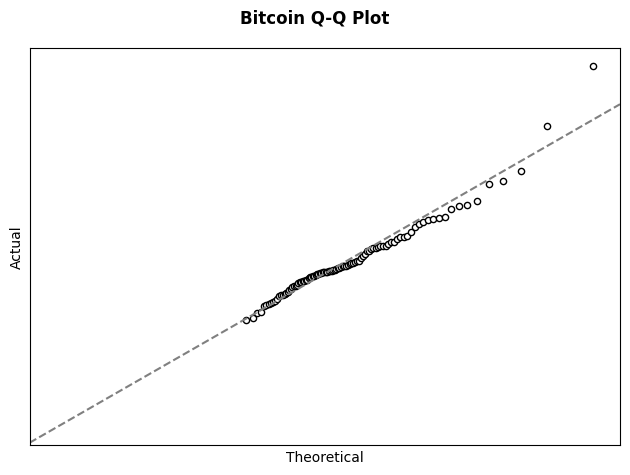

In [83]:
fig, ax = plt.subplots()

ax.scatter(
    x=theory_quantiles,
    y=actual_quantiles,
    s=20,
    color="white",
    linewidths=1,
    edgecolor="black"
)

ax.axline(
    (0, 0), 
    (1, 1),
    linestyle="dashed",
    color="gray"
)
ax.set_xticks([])
ax.set_yticks([])

ax.set_xlabel("Theoretical")
ax.set_ylabel("Actual")

fig.suptitle(
    "Bitcoin Q-Q Plot",
    weight="bold"
)
fig.tight_layout()
pass

### Indices

In [84]:
rv = Normal()
theory_quantiles = [rv.icdf(i) for i in np.linspace(0.01,0.99,99)]
theory_quantiles[:3]

[np.float64(-2.3263478740408408),
 np.float64(-2.053748910631823),
 np.float64(-1.880793608151251)]

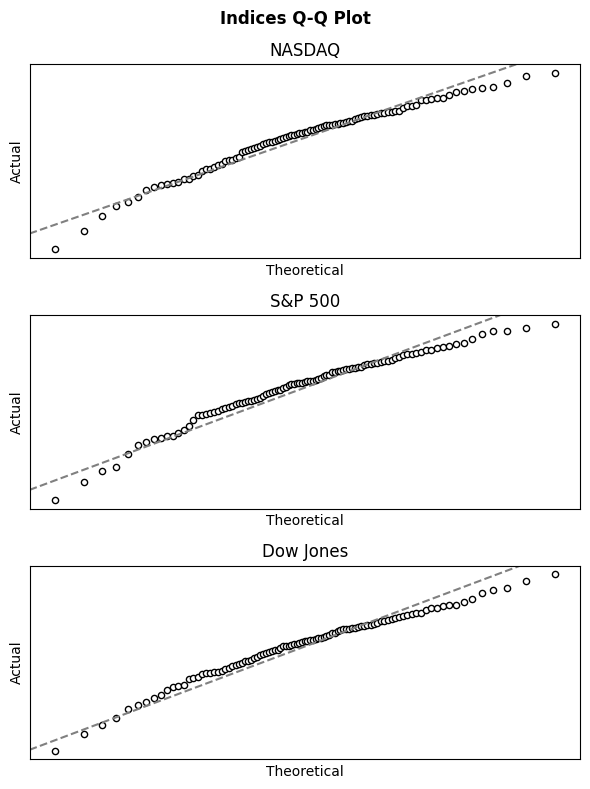

In [86]:
fig, *ax_ = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(6,8)
)
mapping = {
    "nasdaq_ohlc": "NASDAQ",
    "snp_ohlc": "S&P 500",
    "dow_jones_ohlc": "Dow Jones"
}

for ax, (name, data) in zip(ax_[0], pct_changes_z[["nasdaq_ohlc","snp_ohlc","dow_jones_ohlc"]].items()):
    actual_quantiles = data.quantile(
        q=np.linspace(0.01,0.99,99)
    )
    
    ax.scatter(
        x=theory_quantiles,
        y=actual_quantiles,
        s=20,
        color="white",
        linewidths=1,
        edgecolor="black"
    )
    
    ax.axline(
        (0, 0), 
        (1, 1),
        linestyle="dashed",
        color="gray"
    )
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_xlabel("Theoretical")
    ax.set_ylabel("Actual")
    ax.set_title(mapping[name])

fig.suptitle(
    "Indices Q-Q Plot",
    weight="bold"
)
fig.tight_layout()
pass

### Gold

In [53]:
rv = Normal(mu=0, sigma=1) 
theory_quantiles = [rv.icdf(i) for i in np.linspace(0.01,0.99,99)]
theory_quantiles[:3]

[np.float64(-2.3263478740408408),
 np.float64(-2.053748910631823),
 np.float64(-1.880793608151251)]

In [49]:
actual_quantiles = (pct_changes_z["gold_ohlc"]).quantile(
    q=np.linspace(0.01,0.99,99)
)
actual_quantiles.head(3)

0.01   -2.160518
0.02   -1.909734
0.03   -1.764984
Name: gold_ohlc, dtype: float64

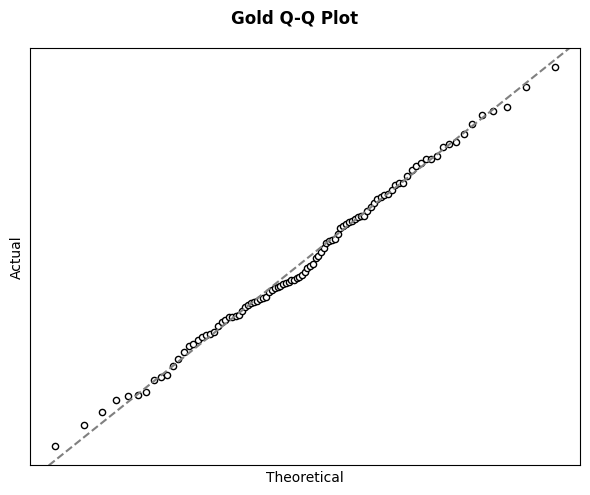

In [50]:
fig, ax = plt.subplots(figsize=(6,5))

ax.scatter(
    x=theory_quantiles,
    y=actual_quantiles,
    s=20,
    color="white",
    linewidths=1,
    edgecolor="black"
)

ax.axline(
    (0, 0), 
    (1, 1),
    linestyle="dashed",
    color="gray"
)
ax.set_xticks([])
ax.set_yticks([])

ax.set_xlabel("Theoretical")
ax.set_ylabel("Actual")

fig.suptitle(
    "Gold Q-Q Plot",
    weight="bold"
)
fig.tight_layout()
pass

### Oil

In [54]:
rv = Normal(mu=0, sigma=1) 
theory_quantiles = [rv.icdf(i) for i in np.linspace(0.01,0.99,99)]
theory_quantiles[:3]

[np.float64(-2.3263478740408408),
 np.float64(-2.053748910631823),
 np.float64(-1.880793608151251)]

In [55]:
actual_quantiles = (pct_changes_z["oil_price"]).quantile(
    q=np.linspace(0.01,0.99,99)
)
actual_quantiles.head(3)

0.01   -2.390914
0.02   -1.910326
0.03   -1.490502
Name: oil_price, dtype: float64

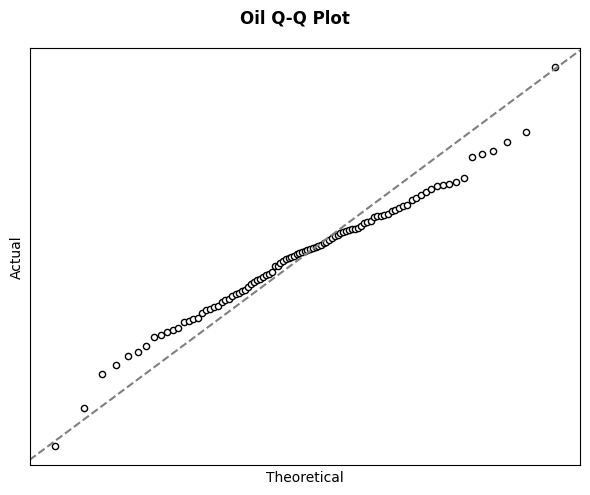

In [56]:
fig, ax = plt.subplots(figsize=(6,5))

ax.scatter(
    x=theory_quantiles,
    y=actual_quantiles,
    s=20,
    color="white",
    linewidths=1,
    edgecolor="black"
)

ax.axline(
    (0, 0), 
    (1, 1),
    linestyle="dashed",
    color="gray"
)
ax.set_xticks([])
ax.set_yticks([])

ax.set_xlabel("Theoretical")
ax.set_ylabel("Actual")

fig.suptitle(
    "Oil Q-Q Plot",
    weight="bold"
)
fig.tight_layout()
pass